# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [206]:
# Imports all in one place

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [187]:
salary = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
print(salary.shape)
salary.head()

(32560, 15)


,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [188]:
salary_new = salary.rename(columns = {'39': 'Age', ' State-gov': 'Business_Status', 
                                      ' Bachelors': 'Education', ' Not-in-family': 'Family_Status', ' White': 'Race', 
                                      ' Male': 'Sex', ' United-States': 'Country', ' <=50K': 'Salary'})
print(salary_new.shape)
salary_new.head()

(32560, 15)


,Age,Business_Status,77516,Education,13,Never-married,Adm-clerical,Family_Status,Race,Sex,2174,0,40,Country,Salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [189]:
salary_new.isnull().sum()

Age                0
Business_Status    0
 77516             0
Education          0
 13                0
 Never-married     0
 Adm-clerical      0
Family_Status      0
Race               0
Sex                0
 2174              0
 0                 0
 40                0
Country            0
Salary             0
dtype: int64

In [190]:
salary_new = salary_new.drop([' 77516', ' 13', ' Never-married', ' Adm-clerical', ' 2174', ' 0', ' 40'], axis = 1)
print(salary_new.columns)
salary_new.dtypes

Index(['Age', 'Business_Status', 'Education', 'Family_Status', 'Race', 'Sex',
       'Country', 'Salary'],
      dtype='object')


Age                 int64
Business_Status    object
Education          object
Family_Status      object
Race               object
Sex                object
Country            object
Salary             object
dtype: object

In [191]:
salary_new.replace('?', np.nan, inplace=True)
salary_new.isnull().sum()

Age                0
Business_Status    0
Education          0
Family_Status      0
Race               0
Sex                0
Country            0
Salary             0
dtype: int64

In [192]:
def encode_cat(df):
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            df[col_name]= df[col_name].astype('category')
            df[col_name] = df[col_name].cat.codes
    return df

salary_new = encode_cat(salary_new)
salary_new.head()

,Age,Business_Status,Education,Family_Status,Race,Sex,Country,Salary
0,50,6,9,0,4,1,39,0
1,38,4,11,1,4,1,39,0
2,53,4,1,0,2,1,39,0
3,28,4,9,5,2,0,5,0
4,37,4,12,5,4,0,39,0


In [193]:
# Splitting data into train_test_split

X = salary_new.drop(['Salary'], axis = 1)
y = salary_new.Salary

In [194]:
salary_new = salary_new.drop(['Salary'], axis = 1)
salary_new.head()

,Age,Business_Status,Education,Family_Status,Race,Sex,Country
0,50,6,9,0,4,1,39
1,38,4,11,1,4,1,39
2,53,4,1,0,2,1,39
3,28,4,9,5,2,0,5
4,37,4,12,5,4,0,39


In [195]:
salary_new.describe()

,Age,Business_Status,Education,Family_Status,Race,Sex,Country
count,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,3.868796,10.298249,1.446376,3.665848,0.669195,36.718796
std,13.640642,1.455879,3.870317,1.606794,0.848817,0.470510,7.823892
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,4.000000,9.000000,0.000000,4.000000,0.000000,39.000000
50%,37.000000,4.000000,11.000000,1.000000,4.000000,1.000000,39.000000
75%,48.000000,4.000000,12.000000,3.000000,4.000000,1.000000,39.000000
max,90.000000,8.000000,15.000000,5.000000,4.000000,1.000000,41.000000


## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


log_reg = LogisticRegression(multi_class='ovr',
                            solver='liblinear',
                            max_iter=500).fit(X, y)
log_reg.score(X,y)

0.7519656019656019

In [197]:
print(X.shape, "\n")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32560, 7) 

(24420, 7)
(8140, 7)
(24420,)
(8140,)


In [198]:
# prediction of salary
y_pred = log_reg.predict(X_train)

Text(0.5, 257.44, 'Predicted label')

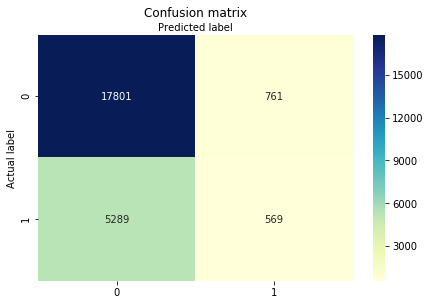

In [199]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)

class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [213]:
# Array of coefficients from the features
# Absolute Value of the coefficients for interpretation
coefs_dict = {'Name':salary_new.columns.tolist(),
              'Coefficient':log_reg.coef_[0], 'Absolute': abs(log_reg.coef_[0])}

coefs = pd.DataFrame(coefs_dict)
coefs.head(7)
# log_reg.coef_

,Name,Coefficient,Absolute
0,Age,0.034420,0.034420
1,Business_Status,0.047545,0.047545
2,Education,0.064142,0.064142
3,Family_Status,-0.224936,0.224936
4,Race,0.126357,0.126357
5,Sex,0.795501,0.795501
6,Country,0.000568,0.000568


In [214]:
# Intercept
print('Intercept for model is ', log_reg.intercept_)


Intercept for model is  [-4.22140317]


In [215]:
# Now scaled
# new dataframe to keep things from before unchanged
scaler = MinMaxScaler()
salary_scaled = salary_new

scaled_cols = salary_scaled.columns.tolist()

# I scale the features
salary_scaled[scaled_cols]
print(salary_scaled.head())
salary_scaled.shape

   Age  Business_Status  Education  Family_Status  Race  Sex  Country
0   50                6          9              0     4    1       39
1   38                4         11              1     4    1       39
2   53                4          1              0     2    1       39
3   28                4          9              5     2    0        5
4   37                4         12              5     4    0       39


(32560, 7)

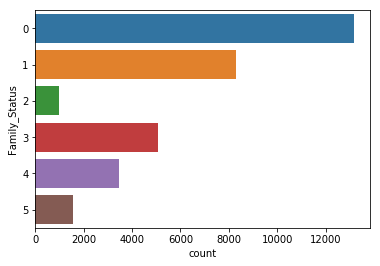

In [216]:
sns.countplot(y = 'Family_Status', data = salary_new)
plt.show()

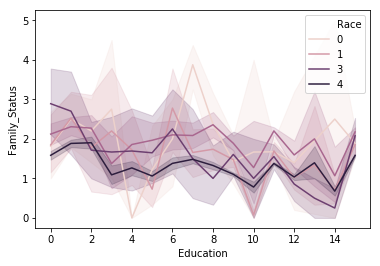

In [217]:
sns.lineplot(salary_new.Education, salary_new.Family_Status, salary_new.Race)
plt.show()

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.



# Answers

- ** 1. Ridge Regression**
- ** 2. Quantile Analysis**
- ** 3. Suirvival Regression**

What are 3 features positively correlated with income above 50k?
What are 3 features negatively correlated with income above 50k?
Overall, how well does the model explain the data and what insights do you derive from it?

In [218]:
top_coefs_pos = coefs.sort_values('Coefficient', ascending = False)
top_coefs_pos.head(4)

,Name,Coefficient,Absolute
5,Sex,0.795501,0.795501
4,Race,0.126357,0.126357
2,Education,0.064142,0.064142
1,Business_Status,0.047545,0.047545


Here are the top four coefficients. Sex, Race, and Education are three that correlate positively with income above 50K. Though the correlation is weak.

In [219]:
top_coefs_pos = coefs.sort_values('Coefficient', ascending = True)
top_coefs_pos.head(4)

,Name,Coefficient,Absolute
3,Family_Status,-0.224936,0.224936
6,Country,0.000568,0.000568
0,Age,0.034420,0.034420
1,Business_Status,0.047545,0.047545


Because salary is our target, that is not applicable. Age, Country, and Family Status are negatively correlated with income above 50K

The results from my model reaffirm a few known characteristics that relate to income. It appears the model is classifying correctly. Sex and Race have always been an issue with income. This just confirms that suspicion. Education also seems to be a factor but not as much as I would have thought.

I was actually surprised Country wasn't more of an issue. I would have thought salaries would be considerably varied depending on what country (exchange rates) you lived in. However, country doesn't seem to be significant here. 

**TODO - your answers!**